In [ ]:
!pip install -q vosk jiwer
!pip install -q git+https://github.com/openai/whisper.git
!apt-get -y install ffmpeg >/dev/null

  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.2/7.2 MB 90.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.2/3.2 MB 89.2 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done


In [ ]:
AMI_AUDIO_DIR = "/content"  # uploaded files land here


In [ ]:
import glob, os
wav_files = sorted(glob.glob(os.path.join(AMI_AUDIO_DIR, "**/*.wav"), recursive=True))
print(f"Found {len(wav_files)} wav files")
print(wav_files[:5])


Found 1 wav files
['/content/EN2002a.wav']


In [ ]:
import os, shutil

# Make refs folder for reference transcripts
os.makedirs("refs", exist_ok=True)

# Rename your uploaded transcript to match the audio file
shutil.copy("meeting_transcript_for_summarizer.txt", "refs/EN2002a.txt")

print("Transcript saved as refs/EN2002a.txt")


Transcript saved as refs/EN2002a.txt


In [ ]:
import wave, json
from vosk import Model, KaldiRecognizer

vosk_model = Model("vosk-model-small-en-us-0.15")

def transcribe_vosk(path):
    wf = wave.open(path, "rb")
    rec = KaldiRecognizer(vosk_model, wf.getframerate())
    rec.SetWords(True)
    text = ""
    while True:
        data = wf.readframes(4000)
        if len(data) == 0:
            break
        if rec.AcceptWaveform(data):
            res = json.loads(rec.Result())
            text += res.get("text", "") + " "
    res = json.loads(rec.FinalResult())
    text += res.get("text", "")
    return text.strip()


In [ ]:
# Download the Vosk model
!wget -q https://alphacephei.com/vosk/models/vosk-model-small-en-us-0.15.zip
!unzip -q vosk-model-small-en-us-0.15.zip

In [ ]:
import whisper
model_whisper = whisper.load_model("base")  # use "small" or "medium" for better quality

def transcribe_whisper(path):
    result = model_whisper.transcribe(path)
    return result["text"].strip()


100%|███████████████████████████████████████| 139M/139M [00:01<00:00, 93.8MiB/s]


In [ ]:
audio_file = "EN2002a.wav"  # make sure your audio is uploaded to /content

vosk_text = transcribe_vosk(audio_file)
whisper_text = transcribe_whisper(audio_file)

# Print full transcripts
print("Vosk Transcript:\n", vosk_text)
print("\nWhisper Transcript:\n", whisper_text)


Vosk Transcript:
 going to come to the meetings as talking about the stuff with the meetings yeah nevertheless the here get certificate right so we really need to talk about the bodies are we just go around and everyone says what they what they've been doing that without anything live say yeah sounds like you've done i could do that i've got a browser now which whoops no good stuff and of mine as well if if given this this wasn't a good start okay sorry yeah say yeah we've got browser read which comes up automatically with or transcription box and the topics and then when you go on the menu you can select some ization box which pops up and an audio player one am and as i think search works as well say pop up a search and loads up just the background when nice empty and so when you start you have to either open open up seek the observation or do such an open it through that that make sense em the transcription boss has got a summarize book button which doesn't do anything it i am now i 

In [ ]:
import time
from jiwer import wer

# --- Load reference transcript ---
with open("refs/EN2002a.txt", "r", encoding="utf-8") as f:
    reference = f.read()

# --- Vosk transcription with timing ---
start = time.time()
vosk_text = transcribe_vosk(audio_file)
vosk_time = time.time() - start

# --- Whisper transcription with timing ---
start = time.time()
whisper_text = whisper_model.transcribe(audio_file)["text"].strip()
whisper_time = time.time() - start

# --- Compute WER ---
vosk_wer = wer(reference, vosk_text)
whisper_wer = wer(reference, whisper_text)

# --- Print results ---
print("Benchmark Results for", audio_file)
print(f" - Vosk    : WER = {vosk_wer:.3f} | Time = {vosk_time:.2f} sec")
print(f" - Whisper : WER = {whisper_wer:.3f} | Time = {whisper_time:.2f} sec")


Benchmark Results for EN2002a.wav
 - Vosk    : WER = 6.383 | Time = 254.75 sec
 - Whisper : WER = 6.107 | Time = 114.45 sec


In [ ]:
import pandas as pd

benchmark = pd.DataFrame([{
    "File": "EN2002a.wav",
    "Vosk_WER": round(vosk_wer, 3),
    "Whisper_WER": round(whisper_wer, 3),
    "Vosk_Time_sec": round(vosk_time, 2),
    "Whisper_Time_sec": round(whisper_time, 2),
}])

benchmark


,File,Vosk_WER,Whisper_WER,Vosk_Time_sec,Whisper_Time_sec
0,EN2002a.wav,6.383,6.107,254.75,114.45


In [ ]:
os.makedirs("outputs", exist_ok=True)
csv_path = "outputs/benchmark_report_EN2002a.csv"
benchmark.to_csv(csv_path, index=False)
print("Benchmark report saved to:", csv_path)


Benchmark report saved to: outputs/benchmark_report_EN2002a.csv


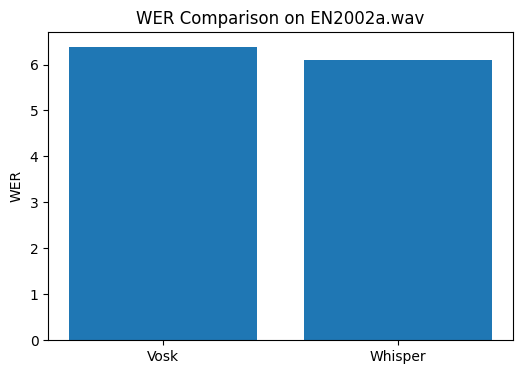

In [ ]:
import matplotlib.pyplot as plt

labels = ["Vosk", "Whisper"]
wers = [vosk_wer, whisper_wer]

plt.figure(figsize=(6,4))
plt.bar(labels, wers)
plt.ylabel("WER")
plt.title("WER Comparison on EN2002a.wav")
plt.show()
